In [15]:
import requests
import json
import pandas as pd
import numpy as np
from functools import reduce
import datetime
import wbdata
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook" # use "pio.renderers" to see the default renderer
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Debt forecasting
- Adapted from this: https://builtin.com/data-science/time-series-forecasting-python

### Load data

In [20]:
# load data
df = pd.read_csv("debt_data.csv",index_col="date", infer_datetime_format=True, parse_dates=True)

# resample to enforce index frequency
# needed for later steps
# reference to frequency strings: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

df = df.resample("AS").mean()
df.sort_index(ascending=False)

,Afghanistan,Angola,Albania,Argentina,Armenia,American Samoa,Azerbaijan,Burundi,Benin,Burkina Faso,Bangladesh,Bulgaria,Bosnia and Herzegovina,Belarus,Belize,Bolivia,Brazil,Bhutan,Botswana,Central African Republic,China,Cote d'Ivoire,Cameroon,"Congo, Dem. Rep.","Congo, Rep.",Colombia,Comoros,Cabo Verde,Costa Rica,Cuba,Djibouti,Dominica,Dominican Republic,Algeria,Ecuador,"Egypt, Arab Rep.",Eritrea,Ethiopia,Fiji,"Micronesia, Fed. Sts.",Gabon,Georgia,Ghana,Guinea,"Gambia, The",Guinea-Bissau,Equatorial Guinea,Grenada,Guatemala,Guyana,Honduras,Haiti,Indonesia,India,"Iran, Islamic Rep.",Iraq,Jamaica,Jordan,Kazakhstan,Kenya,Kyrgyz Republic,Cambodia,Kiribati,Lao PDR,Lebanon,Liberia,Libya,St. Lucia,Sri Lanka,Lesotho,Morocco,Moldova,Madagascar,Maldives,Mexico,Marshall Islands,North Macedonia,Mali,Myanmar,Montenegro,Mongolia,Mozambique,Mauritania,Mauritius,Malawi,Malaysia,Namibia,Niger,Nigeria,Nicaragua,Nepal,Pakistan,Panama,Peru,Philippines,Papua New Guinea,"Korea, Dem. People's Rep.",Paraguay,West Bank and Gaza,Romania,Russian Federation,Rwanda,Sudan,Senegal,Solomon Islands,Sierra Leone,El Salvador,Somalia,Serbia,South Sudan,Sao Tome and Principe,Suriname,Eswatini,Syrian Arab Republic,Chad,Togo,Thailand,Tajikistan,Turkmenistan,Timor-Leste,Tonga,Tunisia,Turkey,Tuvalu,Tanzania,Uganda,Ukraine,Uzbekistan,St. Vincent and the Grenadines,Vietnam,Vanuatu,Samoa,Kosovo,"Yemen, Rep.",South Africa,Zambia,Zimbabwe
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,3.036369e+09,6.728679e+10,1.085924e+10,2.537601e+11,1.309386e+10,NaN,1.581192e+10,6.259853e+08,5.250480e+09,4.494782e+09,6.774904e+10,4.334740e+10,1.426349e+10,4.249122e+10,1.526004e+09,1.542107e+10,5.492343e+11,2.868980e+09,1.597428e+09,9.356300e+08,2.349389e+12,2.507269e+10,1.386390e+10,6.137246e+09,5.253135e+09,1.551718e+11,301131309.5,2.069786e+09,3.128763e+10,NaN,2.678724e+09,328975990.2,4.446774e+10,5.178216e+09,5.619055e+10,1.315797e+11,7.885374e+08,3.036441e+10,1.518014e+09,NaN,7.615876e+09,2.008896e+10,3.132308e+10,4.175377e+09,775654200.1,8.059425e+08,NaN,658742963.7,2.513610e+10,1.506687e+09,1.101662e+10,2.317684e+09,4.175317e+11,5.641790e+11,5.451188e+09,NaN,1.803459e+10,3.801610e+10,1.629744e+11,3.819365e+10,8.697096e+09,1.756206e+10,NaN,1.716414e+10,6.886542e+10,1.480599e+09,NaN,733837563.5,5.634195e+10,1.052218e+09,6.568295e+10,8.475903e+09,4.873178e+09,3.351713e+09,4.675119e+11,NaN,1.060667e+10,6.081078e+09,1.334814e+10,9.722713e+09,3.323621e+10,2.093232e+10,5.710105e+09,1.852748e+10,2.943282e+09,NaN,NaN,4.590696e+09,7.057053e+10,1.205045e+10,7.904918e+09,1.165055e+11,1.088662e+11,7.354921e+10,9.847978e+10,1.797100e+10,NaN,1.976337e+10,NaN,1.423897e+11,4.755182e+11,8.193367e+09,2.295353e+10,1.723862e+10,428927088.9,2.113502e+09,1.833371e+10,4.659652e+09,3.846709e+10,NaN,291188749.4,NaN,766084561.1,4.763248e+09,3.654297e+09,2.546423e+09,2.041466e+11,6.797818e+09,5.636042e+09,231800534.6,194304203.1,4.103810e+10,4.358894e+11,NaN,2.553781e+10,1.720677e+10,1.298991e+11,3.217441e+10,406295764.5,1.250453e+11,455667428.4,437296399.1,3.108498e+09,7.120836e+09,1.707666e+11,3.004589e+10,1.274066e+10
2019-01-01,2.661686e+09,6.444616e+10,9.556856e+09,2.817238e+11,1.188449e+10,NaN,1.584036e+10,5.938894e+08,3.877756e+09,3.686905e+09,5.709417e+10,4.050140e+10,1.323115e+10,4.073412e+10,1.377529e+09,1.430115e+10,5.686459e+11,2.703805e+09,1.56

### Setup

In [22]:
sns.set()

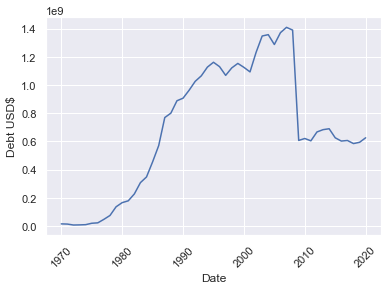

In [26]:
# test plot
plt.ylabel('Debt USD$')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(df.index, df["Burundi"])

In [28]:
# train/test split
country_name = "Burundi"
date_split = pd.to_datetime("2017-01-01", format='%Y-%m-%d')
train = df[country_name][df.index <= date_split]
test = df[country_name][df.index >= date_split]

In [30]:
# deal with missing values
train = train.fillna(method="bfill")
test = test.fillna(method="bfill")

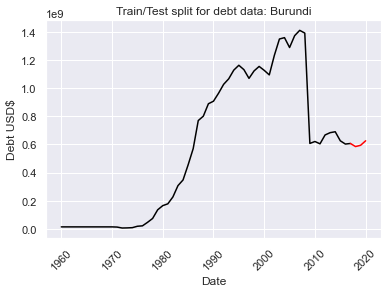

In [34]:
# plot split
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Debt USD$')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for debt data: "+ country_name)
plt.show()

In [36]:
y = train

### ARMA

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [38]:
ARMAmodel = SARIMAX(y, order = (1, 0, 0))

In [39]:
ARMAmodel = ARMAmodel.fit()

In [40]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

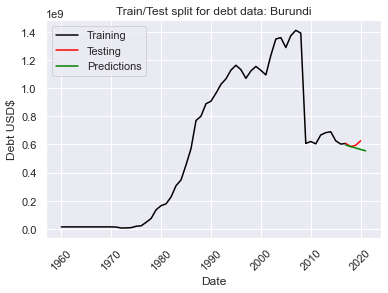

In [42]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.ylabel('Debt USD$')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for debt data: "+ country_name)
plt.legend()

### ARIMA

In [43]:
from statsmodels.tsa.arima.model import ARIMA